<img src="https://drive.google.com/uc?id=1cXtXdAcwedVDbapmz1pj_hULsQrhEcff" width="500"/>

---

# Introduction to convolutional neural networks (CNNs)

In [1]:
import requests
from io import BytesIO
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide1.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide2.png" width="100%"/>

## Excercise:

Let's download an image and look at the raw pixel values.

In [2]:
response = requests.get("https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/camera.tif")
x = torch.tensor(np.array(Image.open(BytesIO(response.content))), dtype=torch.float32)
print(x)
# TODO: look at raw pixel values and plot image


tensor([[156., 159., 158.,  ..., 151., 152., 152.],
        [160., 154., 157.,  ..., 154., 155., 153.],
        [156., 159., 158.,  ..., 151., 152., 152.],
        ...,
        [114., 132., 123.,  ..., 135., 137., 114.],
        [121., 126., 130.,  ..., 133., 130., 113.],
        [121., 126., 130.,  ..., 133., 130., 113.]])


<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide3.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide4.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide5.png" width="100%"/>

# How would you identify these images?

<table>
    <tr>
        <td>
            <img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/cat.png" width="1000">
        </td>
        <td>
            <img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/lena.png" width="1000">
        </td>
        <td>
            <img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/rocket.jpg" width="1000">
        </td>
    </tr>
</table>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/scanning-filter.gif" width="80%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide7.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide8.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide9.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide10.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide11.png" width="100%"/>

## Excercise:

Let's compute a simple convolution on the camera image above, using PyTorch.

In [10]:
# TODO: define a convolutional layer with kernel size = 3, no bias, and show the filter weights
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False)
print(conv.weight) # requires_grad=True: keeps the history of computation for bp

Parameter containing:
tensor([[[[-0.1359,  0.0110, -0.1656],
          [ 0.1257, -0.2840,  0.2443],
          [-0.2423, -0.2650, -0.2106]]]], requires_grad=True)


In [11]:
print(conv)

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)


Now, let's change the weights so that the filter is an "edge detector", and then apply the filter.

In [29]:
x.shape

torch.Size([1, 256, 256])

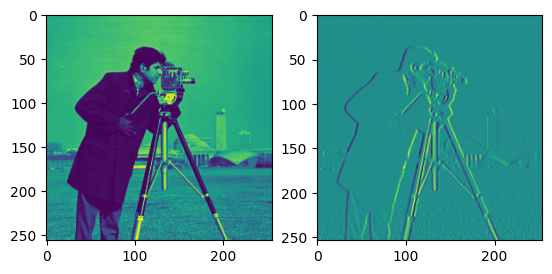

In [30]:
# TODO: change the filter weights so that we detect horizontal edges in the image, and apply the filter to the image
conv.weight.data = torch.tensor([[-1,0,1],
                                [-2,0,2],
                                [-1,0,1]], dtype=torch.float32).reshape(1,1,3,3)

x = x.reshape(1,256,256)
y = conv(x)

plt.figure()
plt.subplot(121)
plt.imshow(x[0])
plt.subplot(122)
plt.imshow(y[0].detach())

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide12.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/conv-dimensions.png" width="100%"/>

## Excercise

Let's extend the convolutional layer above so that we output 3 channels (apply 3 filters) instead of 1.

In [31]:
# TODO: change the layer above so that we output 3 channels, and print the shape of the input, filter, and output
conv = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, bias=False)

x = x.reshape(1,256,256)
y = conv(x)
y.shape

torch.Size([3, 254, 254])

# Convolutions - extensions
<table>
    <tr>
        <td>
            <img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/no_padding_no_strides.gif" width="500">
            <figcaption>Vanilla convolution</figcaption>
        </td>
        <td>
            <img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/no_padding_strides.gif" width="500">
            <figcaption>Stride = 2</figcaption>
        </td>
        <td>
            <img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/same_padding_no_strides.gif" width="500">
            <figcaption>Padding = 1</figcaption>
        </td>
        <td>
            <img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/dilation.gif" width="500">
            <figcaption>Dilation = 2</figcaption>
        </td>
    </tr>
</table>


source: https://github.com/vdumoulin/conv_arithmetic

## Excercise

Next, let's experiment with different settings for the convolutional layer, and see how that changes the output shape.

In [32]:
# TODO: change the settings for the convolutional layer above and predict how the output shape will change
# How does the output shape change with `kernel_size`, `stride`, `padding`, and `dilation`?
# TODO: change the layer above so that we output 3 channels, and print the shape of the input, filter, and output
conv = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, bias=False, stride=2)

x = x.reshape(1,256,256)
y = conv(x)
y.shape

torch.Size([3, 127, 127])

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide14.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide15.png" width="100%"/>

## Excercise:

Now, we are ready to define a convolutional neural network in PyTorch. We will train it to classify MNIST digits.

Step 1: first, we need to download the MNIST dataset.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
train_dataset = datasets.MNIST('./', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)

# TODO: plot an image from the training dataset, and print the size of the two datasets


100%|██████████| 9.91M/9.91M [00:00<00:00, 47.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 3.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.28MB/s]


Step 2: next, we need to define a convolutional neural network in PyTorch. We will use the LeNet5 architecture:

(Lecun et al., (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE)

# LeNet5
<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/lenet5.png" width="100%"/>

Here is the PyTorch machinery we can use to help us:

- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html): Defines and initialises convolutional layers
- [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html): Defines and initialises max pooling layers
- [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): Defines and initialises linear (fully connected) layers
- [`torch.nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html): Defines log softmax operation for output classification layer

In [8]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        #TODO: define the LeNet5 layers
        self.c1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.s2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.c3 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.s4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = torch.nn.Linear(in_features=16*5*5, out_features=10)
    def forward(self, x):

        # TODO: define the forward network function
        x = self.act(self.c1(x))
        x = self.act(self.s2(x))
        x = self.act(self.c3(x))
        x = self.act(self.s4(x))
        x = self.act(self.linear(x))
        return x

    def middle_feature(self, x):
        x = self.act(self.c1(x))
        x = self.act(self.s2(x))
        x = self.c3(x)
        return x

torch.manual_seed(123)
model = LeNet5()

# TODO: check the output dimensions makes sense, and print the shapes of the hidden layer outputs


Step 3: now, we can train the network using a cross entropy (negative log likelihood) loss function, and evaluate its performance on the test set.

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=256)

def train(model, train_loader, epochs=1):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.NLLLoss()# negative log likelihood loss
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):

            # TODO: optimise model


            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

train(model, train_loader)

ValueError: optimizer got an empty parameter list

In [ ]:
def evaluate(model, test_loader):
    "Get model predictions on test dataset"
    model.eval()
    preds, targets = [],[]
    with torch.no_grad():
        for data, target in test_loader:

            # TODO: compute the class probability predictions of the model, and get the most likely class


            preds.append(pred)
            targets.append(target)
    preds = torch.concat(preds)
    targets = torch.concat(targets)

    # TODO: compute the average accuracy on the test set
    acc = preds.eq(targets.sum()) / len(test_dataset)



    plt.figure()
    ConfusionMatrixDisplay.from_predictions(targets, preds, ax=plt.gca(), colorbar=False, cmap='bone_r')
    plt.show()

evaluate(model, test_loader)

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide16.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide17.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide18.png" width="100%"/>

## Excercise
Let's try to interpret what the convolutional neural network has learned.

We can do this by using many different visualisation techniques.

#### Visualising feature maps
A first and easy approach is to visualise the feature maps (outputs) of each convolutional layer.

In [ ]:
x,target = test_dataset[1]

# TODO: plot the feature maps (outputs) for first convolutional layer (model.c1).
# What is each feature sensitive to in the input image?


#### Maximising feature activations
Another approach is to change the input image pixel values such that specific feature is maximised.
This gives us an image which shows us what "maximally activates" that feature.

In [ ]:
def total_variation(image):
    diff_h = torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :])
    diff_w = torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])
    total_variation_loss = torch.sum(diff_h) + torch.sum(diff_w)
    return total_variation_loss

plt.figure(figsize=(11,8))
for fi in range(16):
    print(f"Maximising feature {fi+1} of {16}..")
    torch.manual_seed(123)

    # TODO: optimise a randomly initialised input image to maximally activate the central pixel in the fi feature map of model.c3
    # use TV regularisation with a coefficient of 1.5e-2 to help smoooth the image and adam with lrate=1e-2
    # plot the maximised image and feature value

    plt.subplot(4,4,fi+1)
    plt.imshow(x[0,0].detach())
    plt.title(f"Feature value: {f[:,fi,4,4].item():.2f}")
    plt.axis("off")
    plt.colorbar()
plt.show()

#### Saliency map

Another approach is to generate a "saliency map": this shows which pixels in the image the class prediction is most sensitive to.
More precisely, we compute and plot the gradient of the class prediction with respect to each pixel in the input image.

In [ ]:
x,target = test_dataset[1]

# TODO: compute the gradient of the class prediction wrt the input image pixel values, and plot the saliency map


<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide19.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide20.png" width="100%"/>

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/slides/Slide21.png" width="100%"/>

# Summary
- Convolutional layers learn to recognise **spatial features** in images
- Deep convolutional networks learn **hierarchical** feature representations
- CNNs are used as **common framework** for many computer vision tasks


More materials:
- [But, what is a convolution? 3Blue1Brown video](https://www.youtube.com/watch?v=KuXjwB4LzSA)
- [Introtodeeplearning.com Deep Computer Vision lecture](https://introtodeeplearning.com/) (which this notebook draws inspiration from)